In [1]:
import numpy as np
import matplotlib.pyplot as plt
import CrossCorrelation as cc
from scipy.stats import chi2

### Loading Data

In [2]:
ngrid = 80  # Number of grid points along each axis 
grid_cell_size = 2  # Grid cell size in cMpc/h
boxsize = ngrid * grid_cell_size  # Total box length in cMpc/h
boxsize = np.float32(boxsize)  # Convert integer to float32

z = 6
data_dir = 'GADGET-2_Runs/files_z006.00/'

# Load galaxy data
galaxy_data = np.load(data_dir + f'galaxies_z{z}.npz')

# Extract the stored arrays
positions = galaxy_data['positions']  # Shape (N,3)
muv = galaxy_data['muv']  # Shape (N,)

print(f"Loaded galaxy data for z={z}: positions shape {positions.shape}, muv shape {muv.shape}")

# Load field data
field_data = np.load(data_dir + f'fields_z{z}.npz')

# Extract the stored arrays
qion = field_data['qion']  # Shape (80,80,80)
del_m = field_data['del_m']  # Shape (80,80,80)
del_HI = field_data['del_HI']  # Shape (80,80,80)

print(f"Loaded field data for z={z}: qion shape {qion.shape}, del_m shape {del_m.shape}, del_HI shape {del_HI.shape}")

magnitude_min = -25
magnitude_max = -17
mask = (muv >= magnitude_min) & (muv <= magnitude_max)
pos = positions[mask]
pos = pos.astype(np.float32)  
print(f"We select {len(pos)} galaxies, and store their positions in an array of shape {np.shape(pos)}")

Loaded galaxy data for z=6: positions shape (1459007, 3), muv shape (1459007,)
Loaded field data for z=6: qion shape (80, 80, 80), del_m shape (80, 80, 80), del_HI shape (80, 80, 80)
We select 225425 galaxies, and store their positions in an array of shape (225425, 3)


### Setting up parameters

In [3]:
boxsize = 160 # Mpc/h
thickness = 1 # Mpc/h
bin_len = 16
n_gal = len(pos)

### Example Use case

In [4]:
n_data = 20
n_null = 500
bins_xi = np.linspace(3,20,bin_len)
xi, xi_null = cc.Sampling2ptCC(bins_xi, boxsize, pos, del_HI, thickness, n_gal, n_data, n_null)

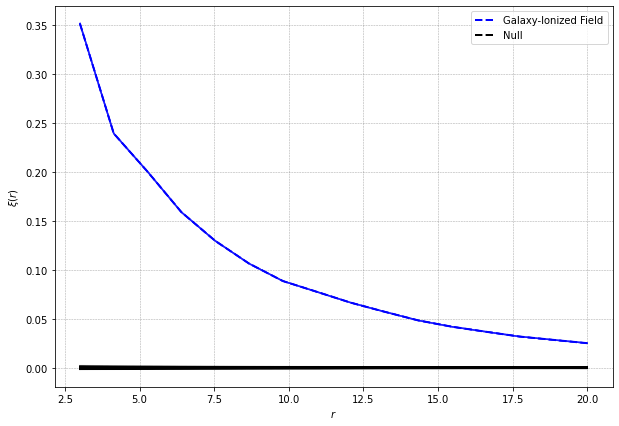

In [5]:
# Plotting for 2-point cross correlation
plt.figure(figsize=(10, 7))
for i in range(n_data):
    plt.plot(bins_xi,xi[i],color='b',alpha=0.1)
for i in range(n_null):    
    plt.plot(bins_xi,xi_null[i],color='k',alpha=0.1)
plt.plot(bins_xi, np.mean(xi, axis=0), color='b', ls='dashed',label='Galaxy-Ionized Field',lw=2) 
plt.plot(bins_xi, np.mean(xi_null, axis=0), color='k', ls='dashed',label='Null',lw=2) 

plt.ylabel(r'$\xi(r)$')
plt.xlabel(r'$r$')
plt.legend()
# plt.yscale('log')
plt.grid(True)  
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

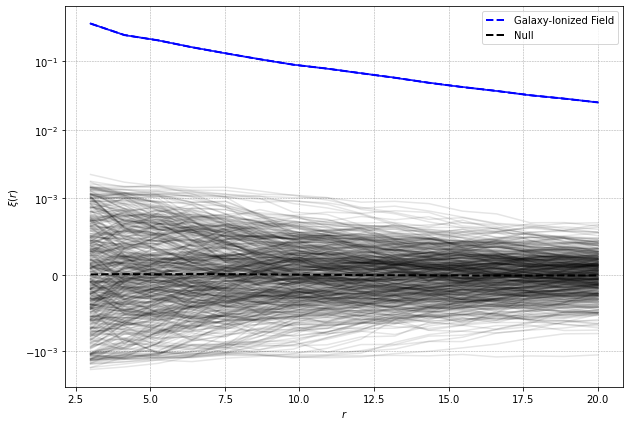

In [6]:
plt.figure(figsize=(10, 7))

for i in range(n_data):
    plt.plot(bins_xi, xi[i], color='b', alpha=0.1)
for i in range(n_null):    
    plt.plot(bins_xi, xi_null[i], color='k', alpha=0.1)

plt.plot(bins_xi, np.mean(xi, axis=0), color='b', ls='dashed', label='Galaxy-Ionized Field', lw=2) 
plt.plot(bins_xi, np.mean(xi_null, axis=0), color='k', ls='dashed', label='Null', lw=2) 

plt.ylabel(r'$\xi(r)$')
plt.xlabel(r'$r$')
plt.legend()

plt.yscale('symlog', linthresh=1e-3)  # log-like but safe for values near 0
plt.grid(True, color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

### Convergence Tests

In [7]:
N_array = [200, 400, 600, 800, 1000, 1500, 2000]
covariances = {}  # dictionary to store cov matrices keyed by n_null

for n_null in N_array:
    xi, xi_null = cc.Sampling2ptCC(bins_xi, boxsize, pos, del_HI, thickness, n_gal, n_data, n_null)
    
    cov_2pt = np.cov(xi_null, rowvar=False, bias=True)
    covariances[n_null] = cov_2pt  # store the raw covariance matrix
#     hartlap = (n_null - bin_len - 2) / (n_null - 1)
#     c_inv_2pt = hartlap * np.linalg.inv(cov_2pt)

###  Shape Convergence Test

This test compares the *overall pattern* or *shape* of the covariance matrix elements by computing the correlation coefficient between the flattened covariance matrices:

$$
\text{Correlation} = \mathrm{corr}\big(\mathrm{vec}(\mathbf{C}_{n_{\mathrm{null}}}), \mathrm{vec}(\mathbf{C}_{\mathrm{ref}})\big)
$$

where $\mathbf{C}_{n_{\mathrm{null}}}$ is the covariance matrix estimated with $n_{\mathrm{null}}$ samples, and $\mathbf{C}_{\mathrm{ref}}$ is the reference covariance matrix computed from the largest sample size.

- This correlation ignores absolute numerical differences and tests if *relative behavior* between matrix elements is consistent.
- The error plotted is:

$$
1 - \mathrm{corr}(\mathbf{C}_{n_{\mathrm{null}}}, \mathbf{C}_{\mathrm{ref}})
$$

- A small value (close to zero) means the *pattern* of covariance element variation is stable and trustworthy even if the exact values differ.

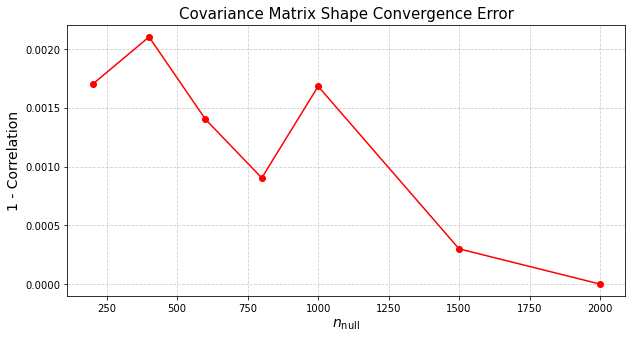

In [8]:
# Reference covariance matrix
cov_ref = covariances[max(N_array)]

# Compute correlation errors
corr_errors = []
for n_null in N_array:
    corr = np.corrcoef(
        covariances[n_null].flatten(),
        cov_ref.flatten()
    )[0, 1]
    corr_errors.append(1 - corr)  # deviation from perfect correlation

# Plot
plt.figure(figsize=(10, 5))
plt.plot(N_array, corr_errors, marker='o', color='red')
plt.xlabel(r'$n_{\mathrm{null}}$', fontsize=14)
plt.ylabel('1 - Correlation', fontsize=14)
plt.title('Covariance Matrix Shape Convergence Error', fontsize=15)
#plt.yscale('log')  # log scale to see small errors clearly
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

### Frobenius Norm Difference

This test measures the relative numerical difference between covariance matrices using the Frobenius norm:

$$
\text{Relative Frobenius difference} = \frac{\| \mathbf{C}_{n_{\mathrm{null}}} - \mathbf{C}_{\mathrm{ref}} \|_F}{\| \mathbf{C}_{\mathrm{ref}} \|_F}
$$

where 

$$
\| \mathbf{A} \|_F = \sqrt{\sum_{i,j} A_{ij}^2}
$$

- This test captures the *total numerical deviation* summed over all elements.
- Smaller values indicate stronger agreement in *exact numbers* — a stricter condition than the shape test.

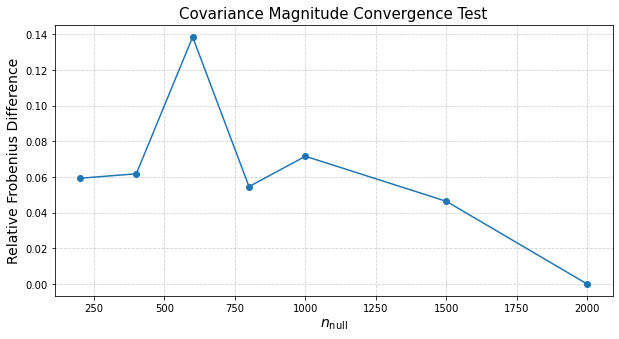

In [9]:
from numpy.linalg import norm

# Pick reference covariance (largest n_null)
cov_ref = covariances[max(N_array)]

# Compute relative Frobenius norms
diff_norms = []
for n_null in N_array:
    diff = norm(covariances[n_null] - cov_ref, ord='fro') / norm(cov_ref, ord='fro')
    diff_norms.append(diff)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(N_array, diff_norms, marker='o')
plt.xlabel(r'$n_{\mathrm{null}}$', fontsize=14)
plt.ylabel('Relative Frobenius Difference', fontsize=14)
plt.title('Covariance Magnitude Convergence Test', fontsize=15)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

### Eigenvalue Convergence

This tracks the convergence of the *principal modes* of variation (leading eigenvalues of the covariance):

$$
\tilde{\lambda}_i(n_{\mathrm{null}}) = \frac{\lambda_i(n_{\mathrm{null}})}{\lambda_i(n_{\max})}
$$

where $\lambda_i(n)$ is the $i^{th}$ eigenvalue of $\mathbf{C}_n$, and $n_{\max}$ corresponds to the largest sample size.

- Normalization by $\lambda_i(n_{\max})$ removes scale differences and highlights relative stability.
- Stabilized eigenvalues mean the main directions of variance are reliably estimated.
- If eigenvalues fluctuate strongly with $n_{\mathrm{null}}$, more samples are needed.

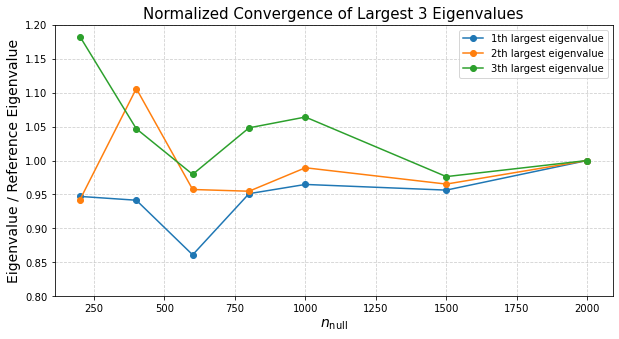

In [10]:
# Store eigenvalues for each n_null
eigvals_dict = {}
for n_null in N_array:
    eigvals = np.linalg.eigvalsh(covariances[n_null])
    eigvals_dict[n_null] = eigvals

# Reference eigenvalues (largest n_null)
n_ref = max(N_array)
eigvals_ref = eigvals_dict[n_ref]

# Sort N_array for consistent plotting
N_array_sorted = sorted(N_array)

# Pick how many largest eigenvalues to track
k = 3
plt.figure(figsize=(10, 5))

for i in range(1, k + 1):  # i=1 is largest, i=k is kth largest
    eigvals_k = [eigvals_dict[n][-i] / eigvals_ref[-i] for n in N_array_sorted]
    plt.plot(N_array_sorted, eigvals_k, marker='o', label=f'{i}th largest eigenvalue')

plt.xlabel(r'$n_{\mathrm{null}}$', fontsize=14)
plt.ylabel('Eigenvalue / Reference Eigenvalue', fontsize=14)
plt.title(f'Normalized Convergence of Largest {k} Eigenvalues', fontsize=15)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.ylim(0.8, 1.2)  
plt.show()